#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [2]:
seed = 0
noise = False 
version = 1 
lr = 1e-4
sample_size = 2000
warmup_ratio = 0.25
batch_size = 16
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25

#### **Seed**

In [3]:
np.random.seed(seed)

#### **Set Up Paths**

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Bold.ttf


#### **First Stage Function**

In [6]:
disabilities = [
    "good health",
    "mobility impairments",
    "blindness",
    "deafness",
    "multiple sclerosis",
    "cerebral palsy",
    "severe depression",
    "bipolar disorder",
    "schizophrenia",
    "anxiety disorders",
    "autism",
    "diabetes",
    "heart disease",
    "HIV/AIDS",
    "a major surgery",
    "a severe injury",
    "pneumonia",
    "Post-Traumatic Stress",
    "rehabing from addiction"
]

# List of most severe disabilities
most_severe = [
    "blindness",
    "deafness",
    "multiple sclerosis",
    "cerebral palsy",
    "severe depression",
    "bipolar disorder",
    "schizophrenia",
    "HIV/AIDS",
    "heart disease"
]

# Create a list of (0,1)s
severity_indicator = [1 if disability != 'good health' else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return .35*(severity_indicator[var5]) + 0.35*var9 + .1

In [7]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

#### **Read in Data**

In [8]:
string_b = 'Based on the following information, predict whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += ' But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free lawyer, tenants with vouchers and disabilities are prioritized over other tenants.'

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

In [9]:
df['FullDescription'][1]

"Based on the following information, predict whether the tenant will be represented in court by a lawyer.\n\n Description:The tenant is a 55-year-old individual who has been residing in a small apartment complex for the past 8 months. Despite having good health, they have fallen behind on their rent, which currently stands at $884. The tenant lives alone, but they receive financial support from their family members who contribute to the rent payments. One of the tenant's hobbies is participating in cooking classes, which they thoroughly enjoy. The tenant's small apartment is home to a beloved bird, which brings them joy and companionship. Overall, the tenant is facing financial difficulties, but they remain resilient and continue to engage in activities, such as cooking classes, that bring them fulfillment.\n\n Note: The tenant has access to a free lawyer. But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free l

In [10]:
to_markdown(df['FullDescription'][0])

> Based on the following information, predict whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 46-year-old individual who has been living in a two-story duplex with a housing voucher for the past 14 months. They are currently struggling to pay the $1305 rent due to financial difficulties. Despite having good health, the tenant's situation has been complicated by the fact that they have a roommate who does not contribute to the rent payments. In addition to their rental obligations, the tenant also operates a side business selling handmade items, which helps supplement their income. However, the revenue from this venture has not been enough to cover the full cost of the rent. As a result, the tenant is facing the possibility of falling behind on their payments and potentially facing eviction proceedings.The tenant's situation highlights the challenges that many individuals face in maintaining stable housing, even with the support of a housing voucher. The presence of a non-contributing roommate and the need to rely on a side business to make ends meet add to the complexity of the tenant's financial situation, underscoring the importance of affordable and accessible housing options for those in need.
> 
>  Note: The tenant has access to a free lawyer. But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free lawyer, tenants with vouchers and disabilities are prioritized over other tenants.

#### **Plot**

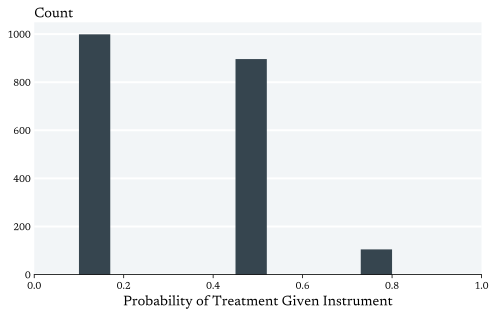

In [11]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Set Up Device**

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **QLora**

In [13]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=torch.bfloat16,
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)


#### **Tokenizer**

In [14]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Meta-Llama-3-8B" #"microsoft/phi-3-mini-4k-instruct" #
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def tokenizer_function(example):
  return tokenizer(example["FullDescription"], truncation=True, max_length=512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Model**

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           device_map='auto',
                                                           quantization_config=quantization_config,
                                                           num_labels=2, 
                                                           torch_dtype=torch.bfloat16,
                                                           trust_remote_code=True)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = True
model.config.pretraining_tp = 1
model.config.gradient_checkpointing = False
#model.enable_input_require_grads()
print(model.generation_config)
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


None
trainable params: 13,639,680 || all params: 7,518,572,544 || trainable%: 0.1814
None


#### **DataLoaders**

In [16]:
df = df.rename(columns={'Treatment': 'label'})
df_treated = df.copy()
df_treated.pop('FullDescription')
df_control = df.copy()
df_control.pop('FullDescription')
df_treated = df_treated.rename(columns={'Treated_FullDescription': 'FullDescription'})
df_control = df_control.rename(columns={'Control_FullDescription': 'FullDescription'})

original_dataset = Dataset.from_dict(df[['FullDescription','label']])
treated_dataset = Dataset.from_dict(df_treated[['FullDescription','label']])
control_dataset = Dataset.from_dict(df_control[['FullDescription','label']])

tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['FullDescription'])

tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['FullDescription'])

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['FullDescription'])

tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)

treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### **Optimizer and Scheduler**

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [18]:
class_weights = torch.tensor([1., 1.], device=device) 
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')

#### **Trainer**

In [19]:
yuri = EncoderTrainer(model, optimizer, scheduler, compute_recall, criterion, device, False)
early_stopping = EarlyStopping(patience)

In [20]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(test_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, (recall, _), current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(recall)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 19, Train Loss: 0.0109, Val Loss: 0.5492:  60%|██████    | 18/30 [22:19<14:52, 74.41s/it]


***Early stopping***
Min Validation Loss: 8
Current Epoch: 18


<All keys matched successfully>

#### **Plot Loss History**

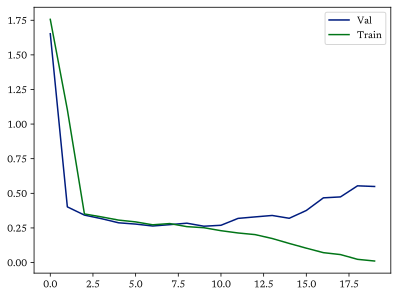

In [21]:
plt.plot(evaluation_losses, label='Val')
plt.plot(training_losses, label='Train')
plt.legend()
plt.show()

#### **Entire Data Set Predictions**

In [22]:
Dhat , labels = predict(model, all_loader, device)

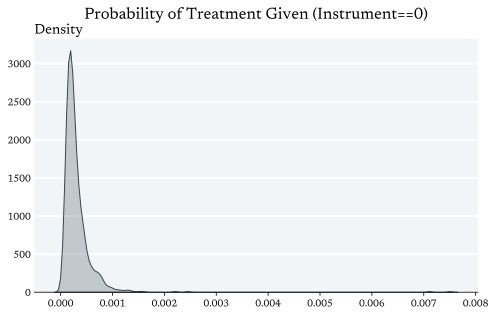

In [23]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==0)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument']==0], color='#36454F', fill=True, bw_adjust=0.5)
plt.ylabel('')
plt.show()

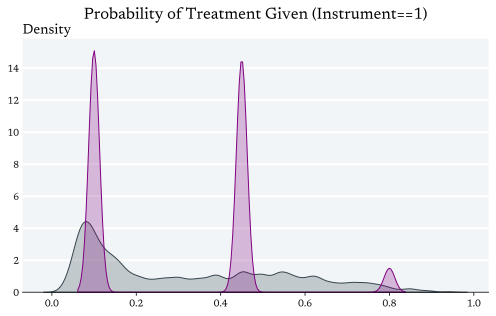

In [24]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument']==1], color='#36454F', fill=True, bw_adjust=0.25)
sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25)
plt.ylabel('')
plt.xlabel('')
plt.show()

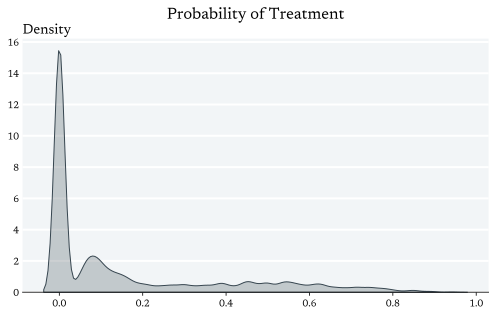

In [25]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat, color='#36454F', fill=True, bw_adjust=0.25)
#sns.kdeplot(df['FStage_Value']*df['label'], color='purple', fill=True, bw_adjust=0.25)
plt.ylabel('')
plt.show()

#### **Save Results**

In [26]:
# Assuming df is your DataFrame and Dhat is already defined in your context
Dhat, _ = predict(model, all_loader, device)
Dhat = Dhat.reshape(-1,1)
Dhat1, _ = predict(model, treated_loader, device)
Dhat1 = Dhat1.reshape(-1,1)
Dhat0, _ = predict(model, control_loader, device)
Dhat0 = Dhat0.reshape(-1,1)
expected_value = (0.5*Dhat1 + 0.5*Dhat0)
residuals = Dhat - expected_value
y = np.array(df['Outcome'].values.reshape(-1,1))
est = np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), y)[0][0]
idx = (np.abs(residuals) > 1e-3).reshape(-1,)
y = np.array(df['Outcome'].values.reshape(-1,1))[idx]
est = np.linalg.lstsq(np.hstack((residuals[idx], np.ones_like(residuals[idx]))), y)[0][0]

<Axes: ylabel='Density'>

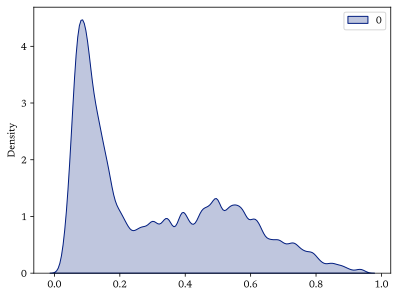

In [27]:
sns.kdeplot(Dhat1, color='#36454F', fill=True, bw_adjust=0.25)


In [28]:
df_result = pd.DataFrame({'Estimate': est})

# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/llama3_{version}_{prompt}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

est

array([3.36489397])

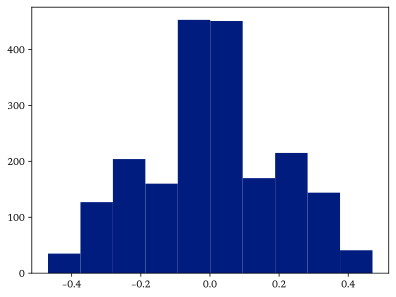

In [29]:
plt.hist(residuals, bins=10)
plt.show()